# ML Term Paper - Code: Binary Models 
by Ann-Christin and Sarah 02/03/2021

## 1. Preparation

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.svm import l1_min_c
from time import time
from sklearn import linear_model

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


from sklearn import ensemble
from sklearn import tree as tree

# set color theme
sns.set_theme()

#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
import os
# path = "E:\Data\krea\PIAAC" #enter your path here
path = "C:/Users/gust/Documents/ML_term_paper"
os.chdir(path)
print("done")
data = pd.read_csv("data/piaac_red.csv", sep=',', error_bad_lines=False, index_col=False)
data.shape

done


C:\Users\gust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,2,5,12,18,23,25,26,29,31,32,39,48,51,58,59,60,63,64,66,69,76,85,86,87,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(230691, 130)

In [3]:
# data cleaning, drop variables that have too few observations,are not relevant or collinear
dcl = data.drop(columns = ['Unnamed: 0', 'cntry', 'cntry_e', 'inpiaac', "racethn_5cat", "unempflag", "racethn_5cat", "c_q08c2", "seqid", "b_q04b", "b_q19a", 
                         "c_q08c2", "learnatwork", "nfehrsnjr", "nfehrsjr", "nfehrs", "earnmthselfppp", "d_q05b2", 
                          "yrsqual_t", "earnmthbonusppp",  "d_q16d5", "c_q02c", "isco1c", "c_d09", "isic1l", "cnt_h", "isced_hf", "isco1l", "isco1c", "c_d05",
                          'icthome','ictwork','b_q01a','b_q01a_t','yrsqual','ageg10lfs','cnt_brth','fnfaet12jr', 'fe12', 'aetpop', 'faet12', 'faet12jr', 'faet12njr', 
                           'nfe12', 'nfe12jr', 'nfe12njr', 'fnfaet12', 'fnfaet12jr', 'fnfaet12njr']) # exlude those to test the results 
#"isic2l", "isic2c", "isic_cus_c", "isic_lus_c", "isic4_c", "isic4_l",

# further exclude 
dcl = dcl.drop(columns = ['d_q16b', 'b_q20b', 'b_d12h', 'b_q02a_t2', 'b_q11', 'b_q12e', 'd_q12a' , 'b_q04a', 'b_q16', 'b_q26b', 'b_q15c', 'd_q06c', 'b_q15b', 'd_q05a2', 
                          'b_q13', 'b_q15a', 'b_q16', 'b_q02a', 'b_q02a_t1', 'b_q05c', 'b_q10b', 'c_d06', 'd_q04', 'b_q12g', 'b_q12b', 'b_q12d'])


dcl = dcl.loc[:, ~dcl.columns.str.endswith('_c')]
#drop if skill level is missing 
#dcl = dcl[dcl.iscoskil4 != "A"]
#dcl = dcl[dcl.iscoskil4 != "N"]
#dcl = dcl[dcl.iscoskil4 != "U"]

In [4]:
#dcl['d_q05a2'] = dcl['d_q05a2'].astype('object')
dcl['gender_r'] = dcl['gender_r'].astype('category')
dcl["age_r"] = pd.to_numeric(dcl["age_r"])
dcl['b_q12a'] = dcl['b_q12a'].astype('category') # yes/no open educational training
#dcl['b_q12b'] = pd.to_numeric(dcl["b_q12b"]) # number of open/distance educational trainings
#dcl["b_q12d"] = pd.to_numeric(dcl["b_q12d"]) # number of on-the-job training
#dcl['b_q12e'] = dcl['b_q12e'].astype('category')  # yes/no seminars training
dcl['b_q12f'] = pd.to_numeric(dcl["b_q12f"]) # number of seminars
#dcl['b_q12g'] = dcl['b_q12g'].astype('category')  # yes/no private training
dcl['b_q12h'] = pd.to_numeric(dcl["b_q12h"]) # number of private educational trainings
# dcl['j_q03a'] = dcl['j_q03a'].astype('category') # yes/no children
dcl['j_q03b'] = pd.to_numeric(dcl['j_q03b']) # number of children
#dcl['yrsqual_t'] = pd.to_numeric(dcl['yrsqual_t'])
dcl['yrsget'] = pd.to_numeric(dcl['yrsget'])
dcl['iscoskil4'] = dcl['iscoskil4'].astype('category')
#dcl['h_q05g'] = dcl['h_q05g'].astype('category') # Skill use everyday life - ICT - Computer - How often - Programming language  
#dcl['g_q05g'] = dcl['g_q05g'].astype('category') # skill use work - ICT programming lanugage how often
#dcl['g_q05'] = dcl['g_q05'].astype('category') # use computer at work yes/no

In [5]:
cate = dcl.select_dtypes(include=['object', 'category'])
cate = cate.drop(columns = ["iscoskil4"]) 
cate = list(set(cate))
cate

['g_q05d',
 'g_q05a',
 'd_q12b',
 'b_q10a',
 'd_q04_t',
 'd_q06b',
 'g_q05h',
 'f_q07b',
 'd_q07a',
 'j_q04a',
 'g_q05e',
 'g_q08',
 'isic1c',
 'd_q06a',
 'b_q14a',
 'f_q07a',
 'b_q10c',
 'vet',
 'b_q01b',
 'nopaidworkever',
 'd_q03',
 'd_q13c',
 'g_q05c',
 'd_q09',
 'c_q02a',
 'g_q07',
 'b_q12c',
 'g_q04',
 'edcat8',
 'computerexperience',
 'pared',
 'b_q14b',
 'd_q12c',
 'g_q05f',
 'b_q12a',
 'g_q05g',
 'd_q14',
 'g_q06',
 'leaver1624',
 'gender_r',
 'b_q26a_t']

In [6]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1

,g_q05d_Every day,g_q05d_Less than once a month,g_q05d_Less than once a week but at least once a month,g_q05d_Never,g_q05a_Every day,g_q05a_Less than once a month,g_q05a_Less than once a week but at least once a month,g_q05a_Never,d_q12b_A lower level would be sufficient,d_q12b_This level is necessary,...,g_q05g_Never,d_q14_Extremely dissatisfied,d_q14_Extremely satisfied,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,g_q06_Moderate,g_q06_Straightforward,"leaver1624_Not in education, did not complete ISCED 3, aged 16 to 24",gender_r_Male,b_q26a_t_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
230687,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
230688,0,0,0,1,1,0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,0
230689,0,0,0,1,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,1,0


In [7]:
# generate dummies                
dummies1 = [pd.get_dummies(dcl[i], prefix=i, drop_first = True) for i in [cate]]
dummies2 =  [pd.get_dummies(dcl["iscoskil4"], prefix="skill")] 
dummies1 = dummies1.pop(0)
dummies1 = pd.DataFrame(dummies1)
dummies2 = dummies2.pop(0)
dummies2 = pd.DataFrame(dummies2)
dummies = dummies1.join(dummies2)
dummies = dummies.drop(columns = ["skill_4","skill_U", "skill_A", "skill_N"])
dummies.head()
dummies.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Columns: 137 entries, g_q05d_Every day to skill_3
dtypes: uint8(137)
memory usage: 30.1 MB


In [8]:
num = dcl.select_dtypes(include=['float64', "int32"])
num = num.loc[:, ~num.columns.str.startswith('b_q12')]

In [9]:
num.head()
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230691 entries, 0 to 230690
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   age_r          166949 non-null  float64
 1   j_q03b         103091 non-null  float64
 2   yrsget         125736 non-null  float64
 3   c_q09          160575 non-null  float64
 4   c_q10a         147420 non-null  float64
 5   readytolearn   226734 non-null  float64
 6   earnmthallppp  88508 non-null   float64
dtypes: float64(7)
memory usage: 12.3 MB


In [10]:
num_list = list(set(num))
num_list

['j_q03b',
 'c_q09',
 'readytolearn',
 'yrsget',
 'earnmthallppp',
 'age_r',
 'c_q10a']

In [11]:
# define X and y
on_job = dummies["b_q12c_Yes"] #define y here
open_educ = dummies["b_q12a_Yes"]
X = num.join(dummies)
X = pd.DataFrame(np.ascontiguousarray(X.values), columns = X.columns)
X = X.drop(columns = ["b_q12c_Yes", "b_q12a_Yes"])
y = pd.DataFrame(dict(on_job=on_job, open_educ =open_educ))
y_X = y.join(X)
y_X

,on_job,open_educ,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05d_Every day,...,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,g_q06_Moderate,g_q06_Straightforward,"leaver1624_Not in education, did not complete ISCED 3, aged 16 to 24",gender_r_Male,b_q26a_t_Yes,skill_1,skill_2,skill_3
0,0,0,NaN,NaN,NaN,NaN,NaN,1.016017,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,NaN,NaN,19.0,NaN,NaN,2.164922,NaN,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0,0,NaN,NaN,NaN,NaN,NaN,1.177736,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,NaN,NaN,NaN,NaN,NaN,2.112932,NaN,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0,1,NaN,NaN,NaN,NaN,NaN,3.064464,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230686,0,0,NaN,NaN,8.0,NaN,NaN,1.177736,NaN,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
230687,0,0,NaN,NaN,11.0,NaN,NaN,2.156445,NaN,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
230688,1,0,NaN,NaN,11.0,NaN,NaN,2.383062,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
230689,0,0,NaN,NaN,12.0,NaN,NaN,1.751830,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 2. Logit

### 2.1 Logit 'on_job'

In [12]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]


In [13]:
X

,age_r,j_q03b,yrsget,c_q09,c_q10a,readytolearn,earnmthallppp,g_q05d_Every day,g_q05d_Less than once a month,g_q05d_Less than once a week but at least once a month,...,d_q14_Neither satisfied nor dissatisfied,d_q14_Satisfied,g_q06_Moderate,g_q06_Straightforward,"leaver1624_Not in education, did not complete ISCED 3, aged 16 to 24",gender_r_Male,b_q26a_t_Yes,skill_1,skill_2,skill_3
18418,33.0,2.0,11.0,6.0,1.0,2.361800,2500.0000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
18423,43.0,1.0,11.0,24.0,1.0,1.124230,1343.1400,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
18433,53.0,2.0,9.0,27.0,2.0,0.788280,980.3900,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
18434,42.0,1.0,11.0,18.0,1.0,1.470600,1314.2200,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18439,50.0,1.0,11.0,29.0,1.0,0.664940,1460.7800,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225548,43.0,2.0,15.0,23.0,1.0,1.239026,6153.8480,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
225552,42.0,2.0,12.0,22.0,1.0,1.177736,3509.6165,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
225554,24.0,1.0,12.0,6.0,15.0,2.004488,2500.0007,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
225555,51.0,3.0,8.0,35.0,2.0,1.002733,929.0080,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                            Results: Logit
Model:                                       Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                          on_job                                   AIC:                                      inf   
Date:                                        2021-03-03 13:01                         BIC:                                      inf   
No. Observations:                            40950                                    Log-Likelihood:                           -inf  
Df Model:                                    131                                      LL-Null:                                  0.0000
Df Residuals:                                40818                                    LLR p-value:                              1.0000
Converged:                                   1.0000                                   Scale:                       

## 2.2 Logit 'off job'

In [15]:
import statsmodels.api as sm 

nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]


In [16]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()
print(result.summary2())

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 8


C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


                                                           Results: Logit
Model:                                      Logit                                    Pseudo R-squared:                         inf   
Dependent Variable:                         open_educ                                AIC:                                      inf   
Date:                                       2021-03-03 13:01                         BIC:                                      inf   
No. Observations:                           40950                                    Log-Likelihood:                           -inf  
Df Model:                                   131                                      LL-Null:                                  0.0000
Df Residuals:                               40818                                    LLR p-value:                              1.0000
Converged:                                  1.0000                                   Scale:                               

C:\Users\gust\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


## 3. Logit with Penalty

## 3.1. 'on job training'

In [17]:
nona = y_X.drop(columns = ["open_educ","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["on_job"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [18]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [19]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')


C: 10
Coefficient of each feature: [[-1.24655769e-02  9.87055893e-03 -1.06187974e-03  1.09588135e-02
   5.83560572e-03 -5.86330336e-02 -1.44695405e-07 -1.78761467e-01
  -2.23132757e-02 -1.32387818e-01  1.93635673e-02  9.27535139e-02
  -3.29724968e-02  1.60900460e-03 -1.37724505e-01  3.82079296e-02
  -2.94019080e-02  2.21859706e-01 -4.44700485e-02  2.07055098e-01
  -1.54510393e-01 -2.62145975e-01  3.23608541e-02  1.17150233e-01
  -1.92713073e-02 -1.58033207e-01  5.66640446e-02 -5.75803663e-02
  -2.74944499e-02  1.45913195e-02  6.44357283e-02 -5.07935777e-02
  -2.42907318e-01 -7.67260196e-01 -1.29620584e-01 -6.14828764e-01
  -2.91084465e-01 -4.37424567e-01 -7.05533789e-01 -6.94319141e-01
  -2.88738473e-01 -9.65657879e-01 -6.77355673e-01 -1.24117021e-01
  -4.30178391e-01 -7.75383708e-01 -4.86195721e-01 -5.18746437e-01
  -3.49378491e-01 -3.07374805e-01 -4.33607350e-01 -6.24283279e-01
  -1.41463818e+00  8.93038172e-01  2.89931424e-01  6.01233525e-01
   4.79626708e-01  6.37913558e-01 -2.4848

Computing regularization path ...
This took 78.937s


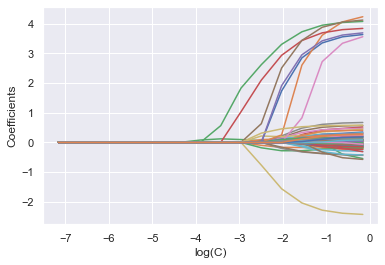

In [20]:
# regularization path

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_on_job.png', bbox_inches='tight')
plt.show()

In [21]:
clf = LogisticRegression(penalty='l1', C=10, solver='liblinear')
logit = clf.fit(X_train, y_train)


y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[6604,  704],
       [1362, 3615]], dtype=int64)

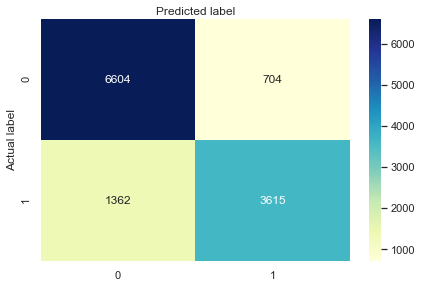

In [22]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_on_job.png', bbox_inches='tight')

In [23]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 

imp = pd.DataFrame(clf.coef_).T
imp['Feature'] = list(X_train.columns)
imp

Coefficient of each feature: [[-1.39559669e-02  1.55005058e-02  3.00112334e-03  1.26015697e-02
   7.47722773e-03 -5.64755662e-02 -1.46567868e-07 -1.89232373e-01
  -2.98066711e-02 -1.42424840e-01  1.08573773e-02  8.38077625e-02
  -4.01212045e-02 -3.58779980e-03 -1.45043479e-01  4.29352078e-02
  -2.65186281e-02  2.22779361e-01 -4.36305435e-02  2.05032425e-01
  -1.50762126e-01 -2.54547288e-01  9.31991880e-03  9.92707024e-02
  -3.94729839e-02 -1.78692128e-01  5.66341563e-02 -3.84262983e-02
  -3.23127734e-02  1.03447451e-02  5.94943444e-02 -5.82597115e-02
  -2.43874201e-01 -5.59462668e-01  5.89762511e-02 -4.13295192e-01
  -9.77359651e-02 -2.37291980e-01 -5.05488628e-01 -4.92989872e-01
  -8.92037250e-02 -7.56467350e-01 -4.87105305e-01  6.83362499e-02
  -2.23267578e-01 -5.76554302e-01 -2.76787089e-01 -3.17166978e-01
  -1.51947044e-01 -9.87104562e-02 -2.23462210e-01 -3.98135455e-01
  -1.19040992e+00  1.11792550e+00  2.96852539e-01  6.07638694e-01
   4.87296725e-01  6.44539665e-01 -2.48569343e+

,0,Feature
0,-0.013956,age_r
1,0.015501,j_q03b
2,0.003001,yrsget
3,0.012602,c_q09
4,0.007477,c_q10a
...,...,...
127,0.135731,gender_r_Male
128,0.555788,b_q26a_t_Yes
129,0.088868,skill_1
130,0.173013,skill_2


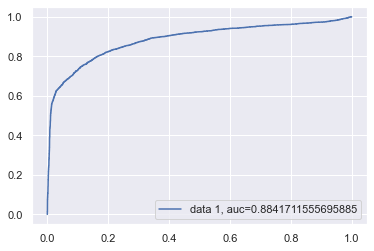

In [24]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\ROC_on_job.png', bbox_inches='tight')
plt.show()

### 3.2 open education

In [25]:
nona = y_X.drop(columns = ["on_job","isic1c_9995", "isic1c_9996", "isic1c_9997", "isic1c_9998", "isic1c_9999"])
nona = nona.dropna()
nona = nona.loc[:, (nona != 0).any(axis=0)]
y = nona["open_educ"]
X = nona.iloc[:, 1:]

# Split the data into test and training sets, with 30% of samples being put into the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [26]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)


In [27]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')


C: 10
Coefficient of each feature: [[ 2.66979688e-03 -7.77268711e-02  2.69693516e-02 -2.97054047e-03
   1.06570393e-02  2.21152136e-02  4.30729902e-08  1.55312646e-01
  -2.22120886e-01  3.41046447e-02 -7.81169164e-02 -1.90929647e-01
  -7.89109598e-02  1.45824522e-01 -5.71255096e-03 -1.07940286e-01
  -1.43514031e-01  6.85904947e-01  1.71700921e-02  1.24008387e-01
   3.03272290e-02  7.60793394e-02  1.43748810e-01 -1.04799247e-01
  -8.38495032e-02 -3.61137545e-01  2.08949707e-01  1.42570186e-01
   8.92295458e-02  4.38915024e-02  7.91195268e-02  1.23767847e-01
  -1.60305571e-01  3.90663001e-01  7.24927139e-01  5.77033622e-01
   9.82123052e-01  7.96704650e-01  6.21297020e-01  7.60827505e-01
   7.61875499e-01  6.25751682e-01  5.89724840e-01  1.07787614e+00
   8.22631060e-01  3.29195202e-01  8.00613696e-01  7.37167775e-01
   8.53348090e-01  5.99482473e-01  6.28368513e-01  4.62068708e-01
   6.78905384e-01  1.27372295e+00  1.33384444e-01  2.57664098e-01
   2.35390942e-01  3.01831561e-01  7.6595

Computing regularization path ...
This took 39.277s


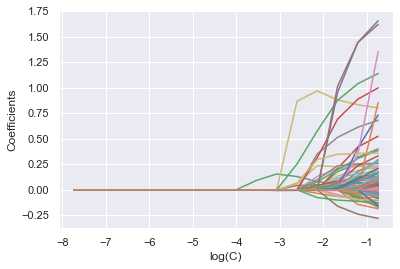

In [28]:
# regularization path (takes a lot of time)

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
#plt.title('Logistic Regression Path')
plt.axis('tight')
plt.savefig('results\plots\lasso_logit_open_educ.png', bbox_inches='tight')
plt.show()

In [29]:
clf = LogisticRegression(penalty='l1', C=10, solver='liblinear')
logit = clf.fit(X_train, y_train)


y_pred=logit.predict(X_test)

from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10918,    79],
       [ 1210,    78]], dtype=int64)

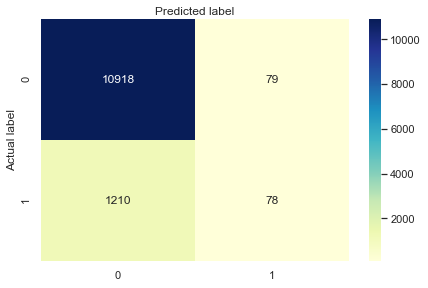

In [30]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('results\plots\confusion_open_educ.png', bbox_inches='tight')

In [31]:
print('Coefficient of each feature:', clf.coef_)
#print('Features:', list(X_train.columns))
print('Training accuracy:', logit.score(X_train_std, y_train))
print('Test accuracy:', clf.score(X_test_std, y_test))
print('') 

imp = pd.DataFrame(clf.coef_).T
imp['Feature'] = list(X_train.columns)
imp

Coefficient of each feature: [[ 2.74795106e-03 -7.76054418e-02  2.71237440e-02 -3.00929847e-03
   1.07846865e-02  2.22672732e-02  4.30595140e-08  1.54874014e-01
  -2.23185517e-01  3.34680803e-02 -7.87499846e-02 -1.90807054e-01
  -7.87738420e-02  1.45780803e-01 -5.52934680e-03 -1.07661656e-01
  -1.43223848e-01  6.86263201e-01  1.76106337e-02  1.23650815e-01
   3.02479299e-02  7.60013860e-02  1.42690168e-01 -1.05601452e-01
  -8.41737364e-02 -3.61925104e-01  2.09077470e-01  1.43624138e-01
   8.91234302e-02  4.38702822e-02  7.88999644e-02  1.23823520e-01
  -1.60346723e-01  3.93802811e-01  7.27333446e-01  5.79626307e-01
   9.84791185e-01  7.99186873e-01  6.23761422e-01  7.63767637e-01
   7.64341700e-01  6.28989179e-01  5.92195155e-01  1.08089077e+00
   8.25546108e-01  3.32494326e-01  8.03430616e-01  7.39886952e-01
   8.56457860e-01  6.02650924e-01  6.30891531e-01  4.65341490e-01
   6.81922688e-01  1.27734535e+00  1.33743578e-01  2.57946315e-01
   2.35583489e-01  3.02078152e-01  7.65888948e-

,0,Feature
0,0.002748,age_r
1,-0.077605,j_q03b
2,0.027124,yrsget
3,-0.003009,c_q09
4,0.010785,c_q10a
...,...,...
127,-0.010496,gender_r_Male
128,0.333585,b_q26a_t_Yes
129,0.156571,skill_1
130,0.205410,skill_2


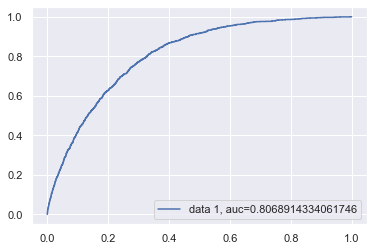

In [32]:
y_pred_proba = logit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.savefig('results\plots\poc_open_educ.png', bbox_inches='tight')
plt.show()